In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import time

In [2]:
# Initialize Spark Session
spark = SparkSession.builder.appName('Predict_Stall_Events').getOrCreate()

24/01/17 00:35:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/17 00:35:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/01/17 00:35:10 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/01/17 00:35:10 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/01/17 00:35:10 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [3]:
# Load the dataset
hdfs_path = "hdfs://hadoop-namenode:9000/assignment/datasets/Dataset-QOE-cleaned.csv"
dataset = spark.read.format("csv").option("header", True).load(hdfs_path)

In [4]:
# Selecting relevant columns and casting them to appropriate types
selected_columns = [
    '95 Input Rate Variation', 'Avg Download Bit Rate', 'Rebuffering Ratio',
    'Avg Video Buffer Level', 'Std Video Download Rate', 'Avg Quality Index',
    'Total Stalling Time', 'Request Duration', 'Bottleneck Bandwidth', 
    'Stall Label', 'Bottleneck Packet Loss',
    'Stall Events'
]

dataset = dataset.select([col(c).cast("float") if c not in ['Bottleneck Packet Loss', 'Stall Label'] else col(c) for c in selected_columns])

In [5]:
# String indexing for categorical columns

indexers = [
    StringIndexer(inputCol='Bottleneck Packet Loss', outputCol='BottleneckPacketLoss_Indexed'),
    StringIndexer(inputCol='Stall Label', outputCol='StallLabel_Indexed')
]

pipeline = Pipeline(stages=indexers)
dataset = pipeline.fit(dataset).transform(dataset)

# Dropping original categorical column after indexing
dataset = dataset.drop('Bottleneck Packet Loss')
dataset = dataset.drop("Stall Label")

24/01/17 00:35:14 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
# Assembling all features into a single feature vector
assembler = VectorAssembler(
    inputCols=[c for c in dataset.columns if c not in ['Stall Events', 'Stall Label']] + ['StallLabel_Indexed'],
    outputCol='features'
)
dataset = assembler.transform(dataset)

In [7]:
# Splitting the dataset into training and testing sets
train_data, test_data = dataset.randomSplit([0.8, 0.2], seed=1234)

In [8]:
# Define the Random Forest Regressor model
rf = RandomForestRegressor(featuresCol='features', labelCol='Stall Events')

In [9]:
# For Time taken (dimensionality Reduction)
start_time = time.time()

In [10]:
# Train the model
rf_model = rf.fit(train_data)

In [11]:
# Make predictions on the test data
predictions = rf_model.transform(test_data)

In [12]:
# For Time taken (dimensionality Reduction)
end_time = time.time()

In [13]:
# Evaluate the model
evaluator = RegressionEvaluator(labelCol='Stall Events', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")
print(f"Time taken: {end_time - start_time} (for Dimensionality Reduction)")

# Show a few predictions
predictions.select('prediction', 'Stall Events').show(10)

Root Mean Squared Error (RMSE) on test data = 0.5017915719874734
Time taken: 2.4073402881622314 (for Dimensionality Reduction)
+------------------+------------+
|        prediction|Stall Events|
+------------------+------------+
| 8.306772023679654|        15.0|
|  8.24030143544436|        10.0|
|7.4060951297274205|         8.0|
|  8.24030143544436|         9.0|
| 8.373438690346322|         7.0|
| 7.958746520054613|        12.0|
|  8.24030143544436|        11.0|
|  1.05101912961737|         1.0|
| 3.393252002190175|         4.0|
| 3.395624902693753|         5.0|
+------------------+------------+
only showing top 10 rows



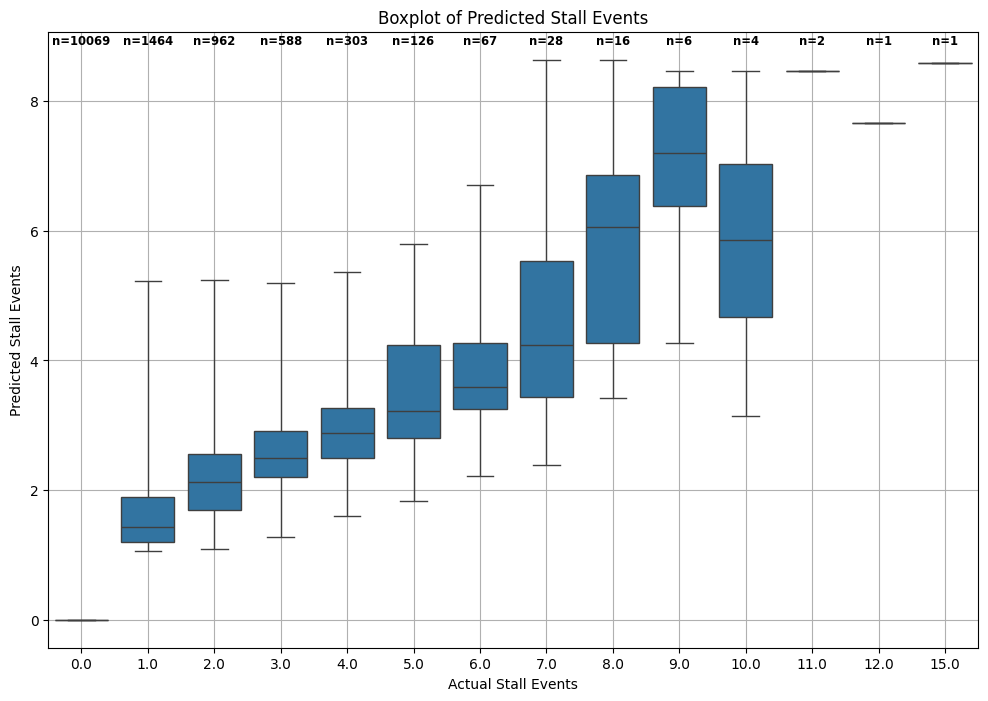

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

results = predictions.select('prediction', 'Stall Events').collect()

predicted_values = [row['prediction'] for row in results]
actual_values = [row['Stall Events'] for row in results]

df = pd.DataFrame({
    'Predicted': predicted_values,
    'Actual': actual_values
})

# Create a boxplot
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='Actual', y='Predicted', data=df, whis=[0, 100])

# Calculate number of observations per category (To annotate)
num_observations = df.groupby('Actual')['Predicted'].size().reset_index(name='counts')
y_offset = 0.2

for i in range(len(num_observations)):
    # Position text above the boxplot
    ax.text(i, ax.get_ylim()[1] - y_offset, f'n={num_observations["counts"][i]}', 
            horizontalalignment='center', size='small', color='black', weight='semibold')

plt.title('Boxplot of Predicted Stall Events')
plt.xlabel('Actual Stall Events')
plt.ylabel('Predicted Stall Events')
plt.grid(True)
plt.show()
